# data preprocessing: gathering, conversion and merging

two data formats:

- customer format: each row is a customer, number of columns can vary

- dayprod format: each row is a combination product - day, number of columns should be fixed
manual modifications from excel should be allowed and suggested.

This second format has to contain at least this four columns: Q, P, prod, date
(but six are automatically returned from the app, with the addition of n_day_sells and n_day_clients)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [ ]:

dati_dp0 = pd.read_csv('storico_vendite_2021-2023.csv', sep=';')
dati_c1 = pd.read_csv('datiCassa_Giugno2025.csv', sep=';')
dati_c2 = pd.read_csv('datiCassa_Settembre2024.csv', sep=';')

dati_i1 = pd.read_csv('impostazioniCassa_Giugno2025.csv', sep=';')
dati_i2 = pd.read_csv('impostazioniCassa2024.csv', sep=';')

dati_i1['prezzo'] = dati_i1['prezzo'].str.replace(',', '.').astype(float)
dati_i2['prezzo'] = dati_i2['prezzo'].str.replace(',', '.').astype(float)

In [ ]:
# functions to make the conversion

def date_miner(df):
    if ('date' in df.columns):
        format_day = "%Y-%m-%d"
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        date_obj = [datetime.strptime(date_str, format_day) for date_str in df['date']]
        df['day'] = [weekdays[date_o.weekday()] for date_o in date_obj]
        df['month'] = [date_o.month for date_o in date_obj]
        df['year'] = [date_o.year for date_o in date_obj]
    return df

def order_cols(df):
    first_cols = ['quantity', 'price', 'prod', 'n_day_sells', 'n_day_orders', 'day', 'month', 'year']
    df_cols = list(df.columns)
    cols = [col for col in first_cols if col in df_cols]
    df = df[cols]
    return df

def save_df(df, name=None):
    if name is None:
        format_str = "%Y-%m-%d %H:%M:%S.%f"
        no = datetime.now().strftime(format_str)
        no = no.replace(':', '_')
        name = 'df_'+no+'.csv'
    df.to_csv(name, sep=';', decimal = '.', index=False)


def customerData_to_dailyData(orders_df, prod_settings):

    ''' beautifoul function that make all the preprocessing from customer data to day product sales data'''

    df = orders_df
    format_str = "%Y-%m-%d %H:%M:%S.%f"
    format_day = "%Y-%m-%d"

    # get dates
    date = [datetime.strptime(ts_str, format_str).date().strftime(format_day) for ts_str in df['ts']]
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    #get quantity by date and product
    cols = list(df.columns)
    last_col_id = cols.index('NOTE')
    prodcols = [cols[i] for i in range(last_col_id+1, df.shape[1])]

    df['date'] = date
    df_long = pd.melt(df, 
                    id_vars=['date'],
                    value_vars=prodcols,
                    var_name='prod',
                    value_name='quantity')

    df_agg = df_long.groupby(['prod', 'date'])['quantity'].sum().reset_index()

    #get time values
    date_obj = [datetime.strptime(date_str, format_day) for date_str in df_agg['date']]
    df_agg['day'] = [weekdays[date_o.weekday()] for date_o in date_obj]
    df_agg['year'] = [date_o.year for date_o in date_obj]
    df_agg['month'] = [date_o.month for date_o in date_obj]

    #get price
    dizio = dict(zip(prod_settings['prodotto'], prod_settings['prezzo']))
    df_agg['price'] = [dizio[o] for o in df_agg['prod']]
    df_agg['price'] = df_agg['price'].str.replace(',', '.').astype(float)

    #get n_day_sells
    date_quantity = df_agg.groupby(['date'])['quantity'].sum().reset_index()
    dizio = dict(zip(date_quantity['date'], date_quantity['quantity']))
    df_agg['n_day_sells'] = [dizio[o] for o in df_agg['date']]

    #get n_day_orders
    unici = np.unique(df['date'], return_counts=True)
    dizio = dict(zip(unici[0], unici[1]))
    df_agg['n_day_orders'] = [dizio[o] for o in df_agg['date']]

    #ordering columns
    df = df_agg[['quantity', 'price', 'prod', 'n_day_sells', 'n_day_orders', 'day', 'month', 'year']]

    return(df_agg)



In [8]:
# convert new dataframes
dati_dp1 = customerData_to_dailyData(dati_c1, dati_i1)
dati_dp2 = customerData_to_dailyData(dati_c2, dati_i2)

# stack dataframes
dati_dp0 = date_miner(dati_dp0)
dati_dp0['price'] = dati_dp0['price'].str.replace(',', '.').astype(float)
dati_dp = order_cols(pd.concat([dati_dp0, dati_dp1, dati_dp2], axis=0, ignore_index=True))

In [9]:
save_df(dati_dp, 'storico_vendite_2021-2025.csv')

In [89]:
# convert a single customer format dataset in day-prod format

#def customer_format_to_dayprod_format(df):
from datetime import datetime

# Define the format of the timestamp string
format_str = "%Y-%m-%d %H:%M:%S.%f"

format_day = "%Y-%m-%d"

df = dati_c1

date = [datetime.strptime(ts_str, format_str).date().strftime(format_day) for ts_str in df['ts']]
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
date_obj = [datetime.strptime(date_str, format_day) for date_str in date]
days = [weekdays[date_o.weekday()] for date_o in date_obj]
years = [date_o.year for date_o in date_obj]
months = [date_o.month for date_o in date_obj]

print(date)
print(days)
print(months)
print(years)

#df['date'] = date


['2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20', '2025-06-20']
['Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 

In [90]:
#get quantity by date and product


cols = list(df.columns)
last_col_id = cols.index('NOTE')
prodcols = [cols[i] for i in range(last_col_id+1, df.shape[1])]

df['date'] = date
df_long = pd.melt(df, 
                  id_vars=['date'],
                  value_vars=prodcols,
                  var_name='prod',
                  value_name='quantity')

df_agg = df_long.groupby(['prod', 'date'])['quantity'].sum().reset_index()


In [91]:
#get price

dizio = dict(zip(dati_i1['prodotto'], dati_i1['prezzo']))
df_agg['price'] = [dizio[o] for o in df_agg['prod']]


In [92]:
#get n_day_sells

date_quantity = df_agg.groupby(['date'])['quantity'].sum().reset_index()

dizio = dict(zip(date_quantity['date'], date_quantity['quantity']))
df_agg['n_day_sells'] = [dizio[o] for o in df_agg['date']]


In [ ]:
#get n_day_orders

import numpy as np

unici = np.unique(df['date'], return_counts=True)
dizio = dict(zip(unici[0], unici[1]))

df_agg['n_day_orders'] = [dizio[o] for o in df_agg['date']]



In [105]:
# stack dataframes

dati_dp0 = date_miner(dati_dp0)
dati_dp = pd.concat([dati_dp0,dati_dp1,dati_dp2], axis=0, ignore_index=True)


In [81]:
print(df_agg[['quantity', 'date', 'prod', 'n_day_sells']])

    quantity        date                prod  n_day_sells
0          1  2025-06-20      anelli cipolla          101
1         14  2025-06-20             anguria          101
2         11  2025-06-20             churros          101
3          2  2025-06-20           cott font          101
4          4  2025-06-20           hamburger          101
5          8  2025-06-20             hot dog          101
6          3  2025-06-20              melone          101
7          0  2025-06-20      panc  scamorza          101
8          2  2025-06-20          panzerotti          101
9         17  2025-06-20            patatine          101
10         4  2025-06-20      pianda nutella          101
11         9  2025-06-20           salamella          101
12         3  2025-06-20   spritz analcolico          101
13         1  2025-06-20         vegetariano          101
14        13  2025-06-20       virgin mojito          101
15         9  2025-06-20  virgin pina colada          101


In [69]:
cols = list(df.columns)
last_col_id = cols.index('NOTE')
prodcols = [cols[i] for i in range(last_col_id+1, df.shape[1])]
print(prodcols)

['hot dog', 'cott font', 'panc  scamorza', 'vegetariano', 'salamella', 'hamburger', 'patatine', 'panzerotti', 'anelli cipolla', 'anguria', 'melone', 'pianda nutella', 'churros', 'virgin mojito', 'virgin pina colada', 'spritz analcolico']


In [ ]:
# aggregate quantities by sum over date and product

import pandas as pd
import io

# Sample data
data = """sandwich,fries,water,day
1,0,0,friday
2,3,1,friday
0,1,1,wednesday"""

df0 = pd.read_csv(io.StringIO(data))

# Use melt to unpivot the DataFrame
df_long = pd.melt(df0, 
                  id_vars=['day'],
                  value_vars=['sandwich', 'fries', 'water'],
                  var_name='prod',
                  value_name='quantity')

print(df_long)

         day      prod  quantity
0     friday  sandwich         1
1     friday  sandwich         2
2  wednesday  sandwich         0
3     friday     fries         0
4     friday     fries         3
5  wednesday     fries         1
6     friday     water         0
7     friday     water         1
8  wednesday     water         1


In [25]:
datetime.strptime(date[0], format_day).year

2025

In [23]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

days = [weekdays[datetime.strptime(date_str, format_day).weekday()] for date_str in date]

print(days)

['Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday']


In [22]:
print(date[0])

2025-06-20


# forecasting methods

workflow:

- load data (ready from preprocessing)

- choose output variable

- choose input variables, and specify if they are numeric or categoric

- choose output transforms, in and out

- choose forecasting model

- make some stats/plots of model performance, and consider train-test split

- make the input form and ranges

- make predictions for the input forms

- transform predictions as output list


In [ ]:
import pandas as pd
import numpy as np

In [10]:
# load data
import pandas as pd
df = pd.read_csv('storico_vendite_2021-2025.csv', sep=';')


In [11]:
# choose output

output = df['quantity'].astype(float)

# choose output transform

mode = 'log' #'ratio'

if mode=='log':
    y = output
    y0 = np.log(1+y)
    y1 = np.exp(y0) - 1
else:
    if mode=='ratio':
        base = df['n_day_sells']
        y = output
        y0 = y/base
        y1 = y0*base



# choose input variables and types

numcols = ['price']

catcols = ['day', 'prod']

df_input = df[numcols+catcols]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
x_categorical = df_input.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = df_input.select_dtypes(exclude=['object']).values
x0 = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values

regressor = RandomForestRegressor(n_estimators=200, random_state=0, oob_score=True, )

regressor.fit(x0, y0)

RandomForestRegressor(n_estimators=200, oob_score=True, random_state=0)

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

preds = regressor.predict(x0)

if mode=='log':
    y1 = np.exp(preds) - 1
else:
    if mode=='ratio':
        y1 = preds*base

mse = mean_squared_error(y, y1)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

r2 = r2_score(y, y1)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.3947851928600523
Mean Squared Error: 99.92915974809927
Root Mean Squared Error: 9.996457359890016
R-squared: 0.7996135351880156


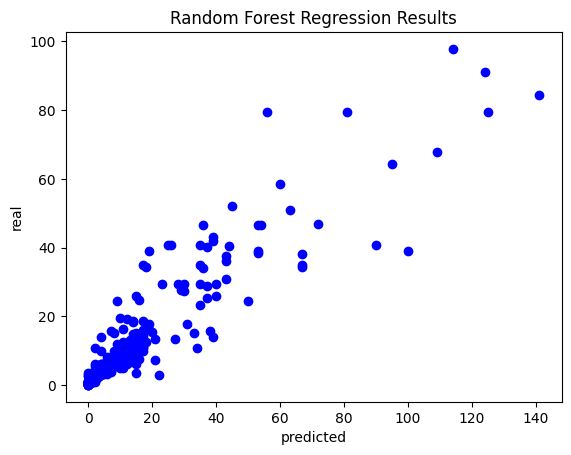

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
   

plt.scatter(y, y1, color='blue')
plt.title("Random Forest Regression Results")
plt.xlabel('predicted')
plt.ylabel('real')
plt.show()

In [ ]:
# run inside jupiter notebook:
# %pip install scikit-learn


  Using cached scikit_learn-1.3.2-cp38-cp38-win_amd64.whl (9.3 MB)
  Using cached scipy-1.10.1-cp38-cp38-win_amd64.whl (42.2 MB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


You should consider upgrading via the 'c:\Users\feder\OneDrive\Documenti\Fede\programmi_idea\Python script\tkinter\cassaPanini\cassaPaninoteca06_github\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [15]:
import sklearn
print(sklearn.__version__)

1.3.2


In [16]:
import sklearn